In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import scipy.stats.mstats as mstats
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns


We first load the data of the three files (train set, test set and store)

In [2]:
store = pd.read_csv("Rossmann/store.csv", low_memory= False)
train = pd.read_csv("Rossmann/train.csv", low_memory= False)
test = pd.read_csv("Rossmann/test.csv", low_memory = False)

train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


We now merge the train and test dataframes with the store dataframe

In [3]:
train = train.merge(store, on="Store", copy=False)
test = test.merge(store, on="Store", copy = False)

train.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In the plot below we see that Mondays are the day with highest average Sales.

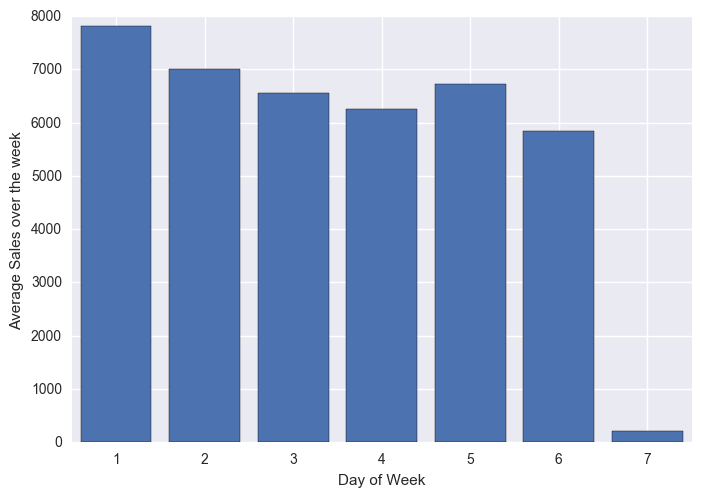

In [4]:
plt.bar([1, 2, 3, 4, 5, 6, 7], train['Sales'].groupby(train.DayOfWeek).mean(), align = "center")
plt.xlabel('Day of Week')
plt.xlim([0.5,7.5])
plt.ylabel('Average Sales over the week')
plt.show()


We also have a look on the impact of a promotion on the amount of sales. We see sales are almost doubled during promotions.

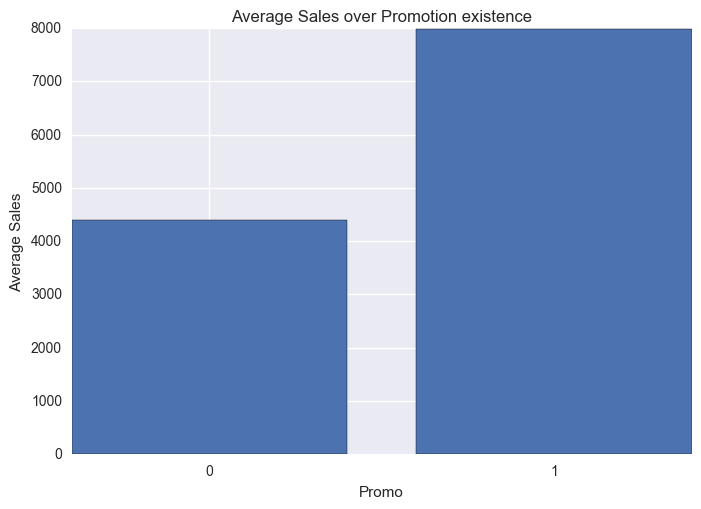

In [5]:
plt.bar([0,1],train.groupby(train.Promo)["Sales"].mean(), align = "center")
plt.xticks(range(2))
plt.xlabel('Promo')
plt.ylabel("Average Sales")
plt.title("Average Sales over Promotion existence")



We next perform some feature engineering/cleaning:

1. We process the "Date" feature, be creating three additional predictors: year, month and WeekOfTheYear. We drop "Date"
2. We create a new feature "MonthsCompetitionExists" that informs about the number of months since a competitor exists. We drop "CompetitionOpenSinceMonth" and "CompetitionOpenSinceYear".
3. We create a new feature "MonthsPromoOpen" that informs about the number of months since a promotion exists. We drop "Promo2SinceWeek", "Promo2SinceYear".
4. We create dummy variables for the categorical data: "StoreType", "Assortment", "DayOfWeek" and "PromoInterval".
5. For the training set, we keep only the rows corresponding to Open = 1 (open stores).
6. We add "StateHoliday_b" and "StateHoliday_c" columns if not present (in the test set).
7. We drop "Store".

In [6]:
def process_data(data):
    processed_df = data.copy()
    processed_df['Date'] = pd.to_datetime(processed_df['Date'])
    processed_df['Year'] = processed_df.Date.apply(lambda x: x.year)
    processed_df['Month'] = processed_df.Date.apply(lambda x: x.month)
    processed_df['WeekOfTheYear'] = processed_df.Date.apply(lambda x: x.weekofyear)
    processed_df.drop(['Date'], axis = 1, inplace= True)
    
    processed_df["MonthsCompetitionExists"] = (processed_df.Year - processed_df.CompetitionOpenSinceYear)* 12 \
        + processed_df.Month - processed_df.CompetitionOpenSinceMonth
    processed_df.MonthsCompetitionExists = processed_df.MonthsCompetitionExists.apply(lambda x: x if x > 0 else 0)
    processed_df.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"], inplace = True, axis = 1)
    
    processed_df["MonthsPromoOpen"] = (processed_df.Year - processed_df.Promo2SinceYear)*12 + \
        processed_df.Month - processed_df.Promo2SinceWeek
    processed_df.MonthsPromoOpen = processed_df.MonthsPromoOpen.apply(lambda x: x if x>0 else 0)
    processed_df.drop(["Promo2SinceWeek", "Promo2SinceYear"], inplace = True, axis = 1)
    
    processed_df = pd.get_dummies(processed_df, columns=["StoreType", "StateHoliday","Assortment", "DayOfWeek", "PromoInterval"])
    
    if 'Sales' in processed_df.columns:
        processed_df = processed_df[processed_df.Open ==1]
        
    for col in ['StateHoliday_b', 'StateHoliday_c']:
        if col not in processed_df.columns:
            processed_df[col] = np.zeros(len(data.index))
        
    processed_df.drop("Store", axis = 1, inplace = True)

    return processed_df

    

In [7]:
processed_train = process_data(train)
processed_train.head()

,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,Year,Month,WeekOfTheYear,...,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
0,5263,555,1,1,1,1270.0,0,2015,7,31,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,5020,546,1,1,1,1270.0,0,2015,7,31,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4782,523,1,1,1,1270.0,0,2015,7,31,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5011,560,1,1,1,1270.0,0,2015,7,31,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6102,612,1,1,1,1270.0,0,2015,7,31,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
processed_train.columns

Index(['Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'Promo2', 'Year', 'Month', 'WeekOfTheYear',
       'MonthsCompetitionExists', 'MonthsPromoOpen', 'StoreType_a',
       'StoreType_b', 'StoreType_c', 'StoreType_d', 'StateHoliday_0',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'Assortment_a',
       'Assortment_b', 'Assortment_c', 'DayOfWeek_1', 'DayOfWeek_2',
       'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6',
       'DayOfWeek_7', 'PromoInterval_Feb,May,Aug,Nov',
       'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec'],
      dtype='object')

We reorder the rows in the test set according to the order in the training set.

In [9]:
processed_test = process_data(test)

processed_test.columns
cols = ["Id", 'Open', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'Promo2', 'Year', 'Month', 'WeekOfTheYear',
       'MonthsCompetitionExists', 'MonthsPromoOpen', 'StoreType_a',
       'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a',
       'Assortment_b', 'Assortment_c', 'StateHoliday_0', 'StateHoliday_a',
        'StateHoliday_b', 'StateHoliday_c', 'DayOfWeek_1', 'DayOfWeek_2', 
        'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6',
       'DayOfWeek_7', 'PromoInterval_Feb,May,Aug,Nov',
       'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec']
processed_test = processed_test[cols]
processed_test.head()

,Id,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,Year,Month,WeekOfTheYear,MonthsCompetitionExists,...,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
0,1,1.0,1,0,1270.0,0,2015,9,38,84.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,857,1.0,1,0,1270.0,0,2015,9,38,84.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1713,1.0,1,0,1270.0,0,2015,9,38,84.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2569,1.0,1,0,1270.0,0,2015,9,38,84.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3425,0.0,0,0,1270.0,0,2015,9,37,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Correlations

We analyze the correlation between different predictors. We observe that Sales and Customers, and Month and WeekOfTheYear are heavily correlated (as expected). There is also a correlation between Promo and Sales, Promo2 and PromoInterval (the months where Promo2 is renewed), and Assortment_b and StoreType_b. None of these correlations are surprising.

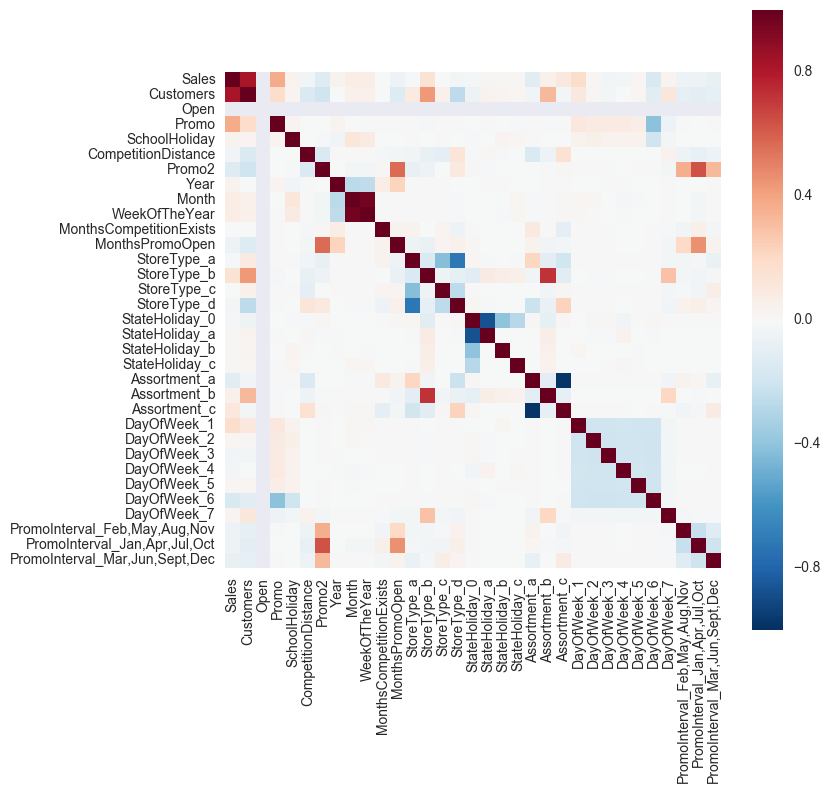

In [10]:
corrmax = processed_train.corr()
plt.subplots(figsize = (8,8))
sns.heatmap(corrmax, square=True)

### Distribution of Sales

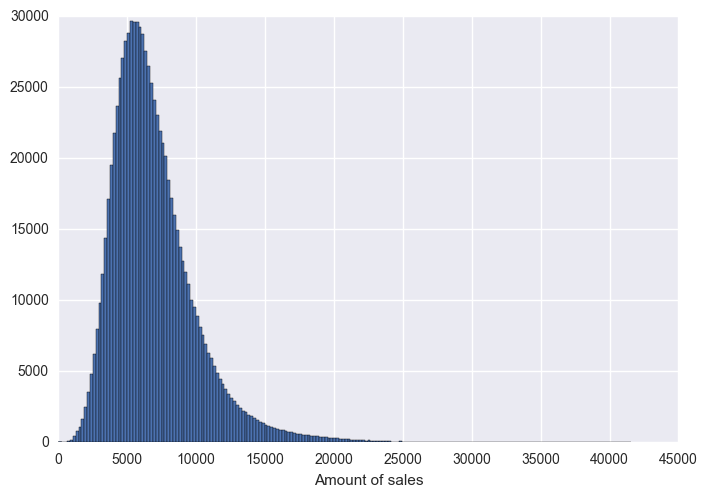

In [11]:
plt.hist(processed_train['Sales'],bins=200)
plt.xlabel('Amount of sales')
plt.show()

It looks like a log-normal distribution, therefore, we will log transform the target Sales. 

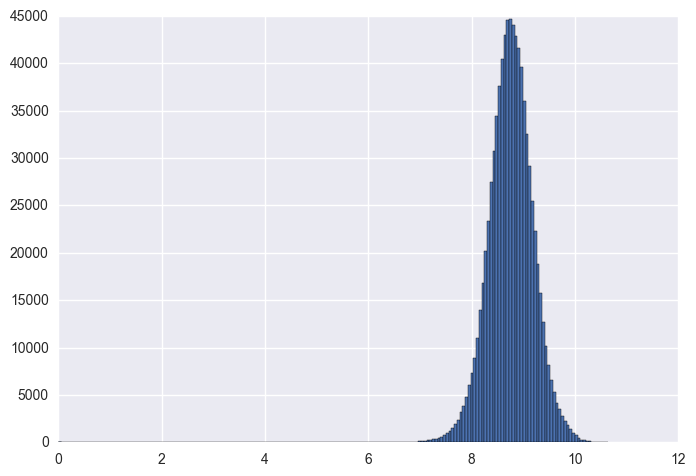

In [12]:
Y_train = processed_train['Sales'].values
Y_transform_train = np.log1p(Y_train)
plt.hist(Y_transform_train,bins=200)
plt.show()

### Linear Regression Model 

We create out target variable Y, and its log-transformation, Y_transform. We also create our array of predictors, X.

In [13]:
Y = processed_train['Sales'].values
Y_transform = np.log1p(Y)

In [14]:
X = processed_train.drop(["Sales", "Customers"], axis=1).values
predictors = processed_train.drop(['Sales', "Customers"], axis=1).columns.values.tolist()
k = len(predictors)

Before training our model, we will create a mask to remove the NaN values.

In [15]:
mask = ~np.any(np.isnan(X),axis=1)
X = X[mask]
Y_transform = Y_transform[mask]
Y = Y[mask]
n=len(Y)

If the distribution is not normal some machine learning algorithme may not perform well. Therefore, we next standardize our features (substract the mean and scale it to variance equal 1). 

In [16]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

#### Linear regression with 10-fold cross validation


In [17]:
kfold = KFold(n_splits=10, random_state=7)
model = LinearRegression()
scoring = 'r2'
results = cross_val_score(model, X_scaled, Y, cv=kfold, scoring=scoring)
print('R^2: %.3f (%.3f)' % (results.mean(), results.std()))

R^2: 0.208 (0.057)


If we look at the residuals, they present heteroskedasticity. Therefore we will try log-transforming the target variable.  

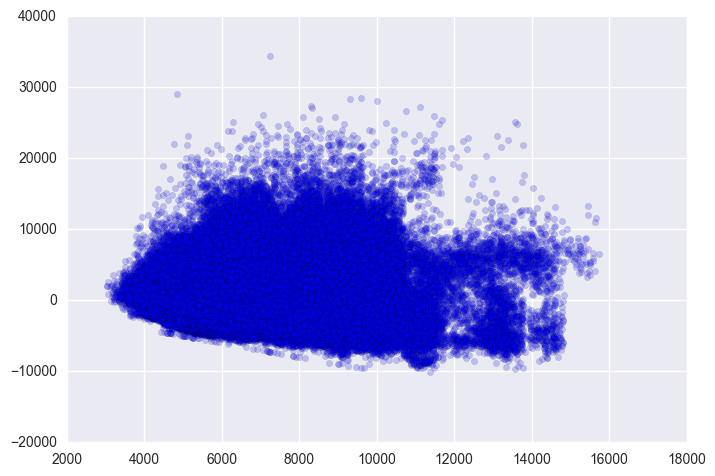

In [18]:
fit = model.fit(X_scaled,Y)
Y_pred = model.predict(X_scaled)
residuals = Y - Y_pred
plt.scatter(Y_pred,residuals,alpha=0.2)
plt.show()

### Linear regression with log-transformed target variable


In [19]:
kfold = KFold(n_splits=10, random_state=7)
model = LinearRegression()
scoring = 'r2'
results = cross_val_score(model, X_scaled, Y_transform, cv=kfold, scoring=scoring)
print('r^2: %.3f (%.3f)' % (results.mean(), results.std()))
print('adj_r^2: %.3f' % (1-(1-results.mean())*(n-1)/(n-k-1)))

r^2: 0.221 (0.049)
adj_r^2: 0.221


With and R^2 of 0.22, we see that a linear model is not performing too well for our problem. Therefore we will try next prediction with Ensemble Methods. In particular, we will use Random Forest Regressor and a Gradient Boosting Regressor.

### Random Forest Regressor

In [20]:
num_trees = 100
max_features = 8
kfold = KFold(n_splits=10, random_state=7)
model = RandomForestRegressor(n_estimators=num_trees, max_features = max_features)
scoring = 'r2'
results = cross_val_score(model, X_scaled, Y_transform, cv=kfold, scoring= scoring)
print('r^2: %.3f (%.3f)' % (results.mean(), results.std()))
print('adj_r^2: %.3f' % (1-(1-results.mean())*(n-1)/(n-k-1)))

r^2: 0.145 (0.089)
adj_r^2: 0.145


Random Forest performance is even worse.

### Gradient Boosting Regressor

In [27]:
n_estimators = 80
max_depth = 10
max_features = 8
kfold = KFold(n_splits=10, random_state=7)
model = GradientBoostingRegressor(n_estimators=n_estimators, max_features = max_features, max_depth = max_depth)
scoring = 'r2'
results = cross_val_score(model, X_scaled, Y_transform, cv=kfold, scoring= scoring)
print('r^2: %.3f (%.3f)' % (results.mean(), results.std()))
print('adj_r^2: %.3f' % (1-(1-results.mean())*(n-1)/(n-k-1)))

r^2: 0.264 (0.080)
adj_r^2: 0.264


Gradient Boosting gives us the best R^2 of all the tested models, it is still not optimal though. Using more estimators, will yield a better R^2 score. The training time of 80 estimators is 150 min approximately.

In [31]:
model.fit(X_scaled, Y_transform)
print (list(zip(predictors,model.feature_importances_)))

[('Open', 0.0), ('Promo', 0.071306942326764516), ('SchoolHoliday', 0.0099226464020699436), ('CompetitionDistance', 0.40452295984290654), ('Promo2', 0.022958810718385212), ('Year', 0.023190770076044052), ('Month', 0.027705184637070335), ('WeekOfTheYear', 0.067492767612903043), ('MonthsCompetitionExists', 0.10733424230708503), ('MonthsPromoOpen', 0.037887066540348083), ('StoreType_a', 0.023723653039232767), ('StoreType_b', 0.010408294252361762), ('StoreType_c', 0.015021986520117072), ('StoreType_d', 0.018695065077920466), ('StateHoliday_0', 0.001224324154844791), ('StateHoliday_a', 0.00069695497789261742), ('StateHoliday_b', 0.00011720709443339939), ('StateHoliday_c', 2.0419216401100824e-05), ('Assortment_a', 0.025740337423135966), ('Assortment_b', 0.001754687614218213), ('Assortment_c', 0.020509366639571851), ('DayOfWeek_1', 0.015422912178396451), ('DayOfWeek_2', 0.0081511606441196684), ('DayOfWeek_3', 0.0044039583697561011), ('DayOfWeek_4', 0.0035305996653250092), ('DayOfWeek_5', 0.008

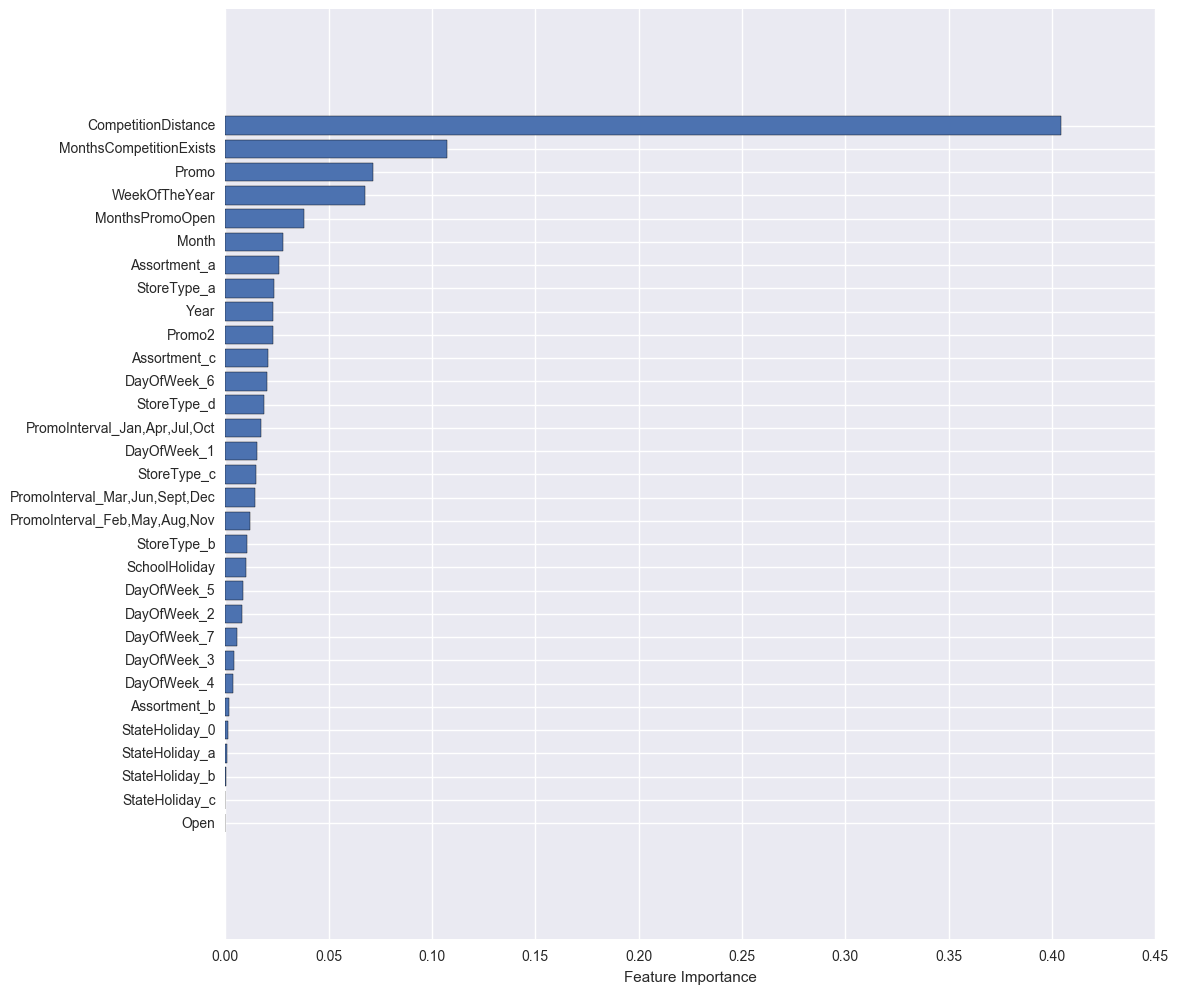

In [33]:
features_importance = zip(predictors,model.feature_importances_)
features_importance = sorted(features_importance, key=lambda x: x[1], reverse= False)
feature = list(zip(*features_importance))[0]
score = list(zip(*features_importance))[1]
x_pos = np.arange(len(feature)) 
plt.rcParams['figure.figsize'] = (12, 12)
plt.barh(x_pos, score,align='center')
plt.yticks(x_pos, feature)
plt.xlabel("Feature Importance")
plt.show()

Our Gradient Boosting Regressor shows that the most important predictors are "CompetitionsDistance" followed by  "MonthsCompetitionExists", "Promo" and "WeekOfTheYear".

In [34]:
processed_test.fillna(1, inplace=True)
processed_test.drop("Id", inplace=True, axis=1)
processed_test.columns
X_test = processed_test.values

scaler = StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)  
   
Y_pred = model.predict(X_test_scaled)
result_gb = pd.DataFrame({'Id': test["Id"], 'Sales': np.expm1(Y_pred)})
result_gb.to_csv("gb_result.csv", index=False)


In [36]:
result_gb

,Id,Sales
0,1,8624.388713
1,857,8279.354843
2,1713,8514.924916
3,2569,9090.421293
4,3425,6532.218159
5,4281,6781.924806
6,5137,6912.599219
7,5993,6512.877201
8,6849,6362.459243
9,7705,6437.560904
